#  Sequence-to-Sequence Prediction with RNN, LSTM, and GRU


In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

##  Data Generation and Preprocessing

In [2]:
def generate_sequence_data(n_samples, sequence_length, vocab_size):
    X = np.random.randint(1, vocab_size, (n_samples, sequence_length))
    Y = np.flip(X, axis=1)
    X_cat = to_categorical(X, num_classes=vocab_size)
    Y_cat = to_categorical(Y, num_classes=vocab_size)
    return X_cat, Y_cat

# Hyperparameters
n_samples = 10000
sequence_length = 10
vocab_size = 15

# Generate and split
X, Y = generate_sequence_data(n_samples, sequence_length, vocab_size)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)

X.shape, Y.shape

((10000, 10, 15), (10000, 10, 15))

##  Model Builder Function

In [3]:
def build_seq2seq_model(cell_type, units=256, dropout_rate=0.2):
    model = Sequential()
    if cell_type == 'RNN':
        model.add(SimpleRNN(units, input_shape=(X.shape[1], X.shape[2]), dropout=dropout_rate))
    elif cell_type == 'LSTM':
        model.add(LSTM(units, input_shape=(X.shape[1], X.shape[2]), dropout=dropout_rate, recurrent_dropout=dropout_rate))
    elif cell_type == 'GRU':
        model.add(GRU(units, input_shape=(X.shape[1], X.shape[2]), dropout=dropout_rate, recurrent_dropout=dropout_rate))
    else:
        raise ValueError("Invalid cell type")

    model.add(RepeatVector(sequence_length))

    if cell_type == 'RNN':
        model.add(SimpleRNN(units, return_sequences=True, dropout=dropout_rate))
    elif cell_type == 'LSTM':
        model.add(LSTM(units, return_sequences=True, dropout=dropout_rate, recurrent_dropout=dropout_rate))
    elif cell_type == 'GRU':
        model.add(GRU(units, return_sequences=True, dropout=dropout_rate, recurrent_dropout=dropout_rate))

    model.add(TimeDistributed(Dense(vocab_size, activation='softmax')))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

##  Model Training

In [4]:
history_dict = {}
for cell_type in ['RNN', 'LSTM', 'GRU']:
    print(f"Training {cell_type} model...")
    model = build_seq2seq_model(cell_type, units=256, dropout_rate=0.2)
    history = model.fit(X_train, Y_train, epochs=30, batch_size=64,
                        validation_data=(X_val, Y_val), verbose=0)
    history_dict[cell_type] = history

Training RNN model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training LSTM model...
Training GRU model...


##  Results Comparison

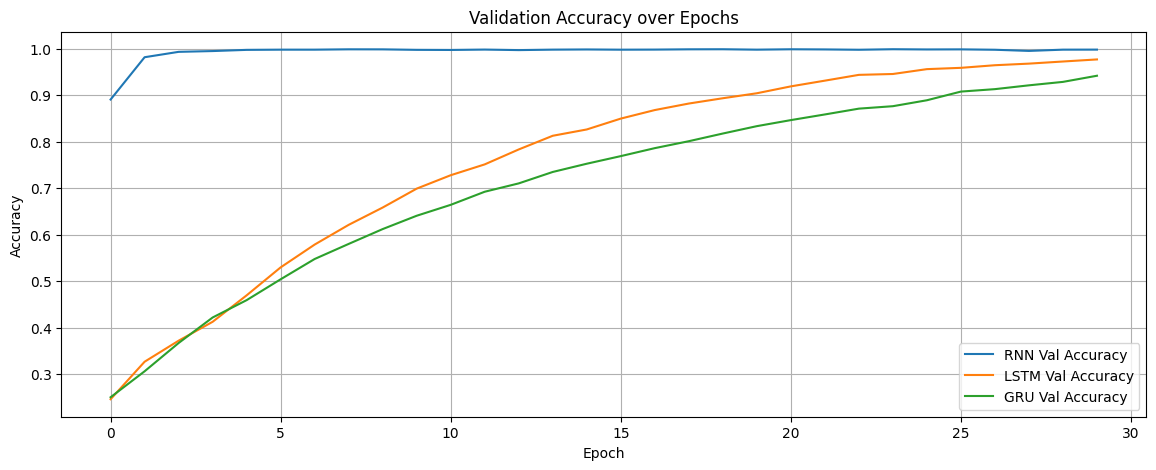

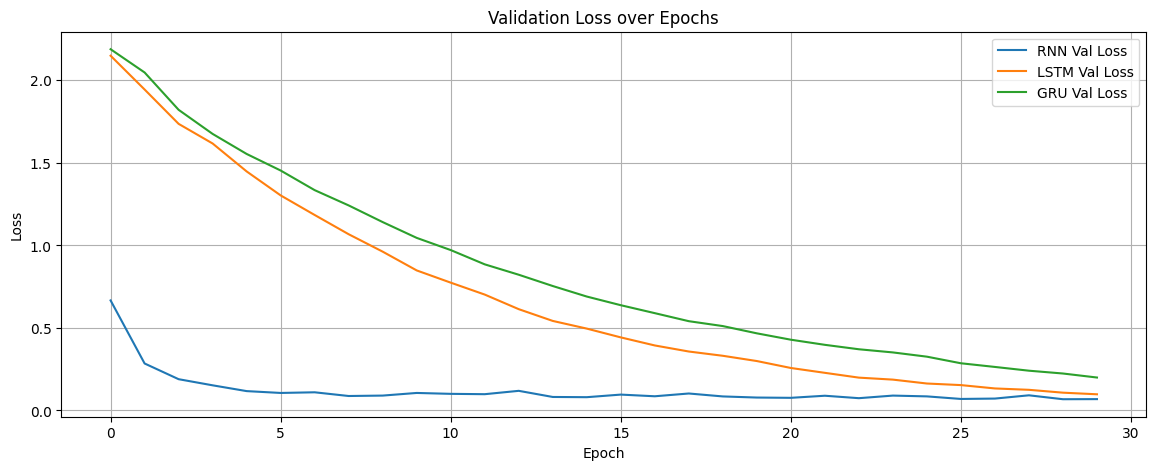

In [5]:
plt.figure(figsize=(14, 5))
for cell_type, history in history_dict.items():
    plt.plot(history.history['val_accuracy'], label=f'{cell_type} Val Accuracy')

plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 5))
for cell_type, history in history_dict.items():
    plt.plot(history.history['val_loss'], label=f'{cell_type} Val Loss')

plt.title('Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

##  Final Accuracy & Loss Summary

  Model  Final Val Accuracy  Final Val Loss
0   RNN              0.9979          0.0685
1  LSTM              0.9768          0.0979
2   GRU              0.9417          0.1994


<Axes: title={'center': '📊 Final Accuracy & Loss Comparison'}, xlabel='Model'>

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


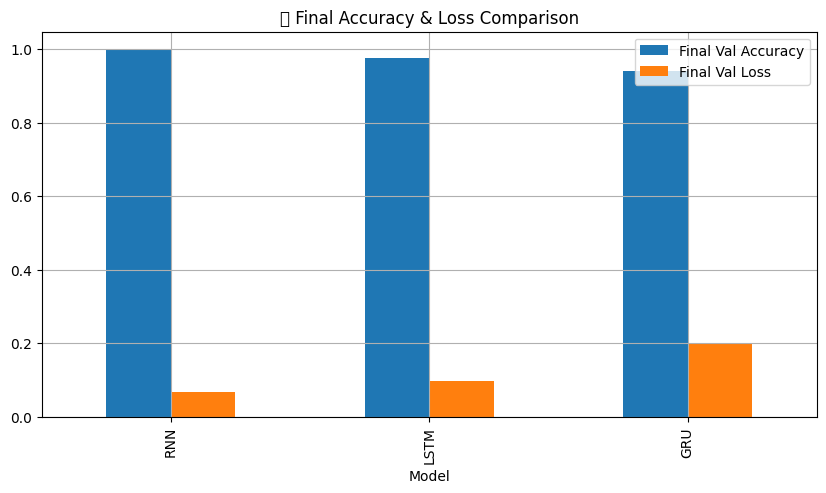

In [6]:
import pandas as pd

# Summarize final accuracy and loss for each model
summary = {
    'Model': [],
    'Final Val Accuracy': [],
    'Final Val Loss': []
}

for cell_type, history in history_dict.items():
    summary['Model'].append(cell_type)
    summary['Final Val Accuracy'].append(round(history.history['val_accuracy'][-1], 4))
    summary['Final Val Loss'].append(round(history.history['val_loss'][-1], 4))

summary_df = pd.DataFrame(summary)
print(summary_df)
summary_df.plot(x='Model', y=['Final Val Accuracy', 'Final Val Loss'], kind='bar', figsize=(10, 5), title="📊 Final Accuracy & Loss Comparison", grid=True)

##  Conclusion

This notebook demonstrates that for a simple sequence reversal task:

- **RNN** can learn basic patterns but often struggles with longer-term dependencies.
- **LSTM** shows strong performance and stability due to its internal memory gates.
- **GRU** often matches or slightly trails LSTM performance while being computationally lighter.

